<a href="https://colab.research.google.com/github/naufalridha99/Tugas-Mechine-Learning/blob/main/UAS/ResNet_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UAS**

**CNN with ResNet for MNIST image classification.**

In [ ]:
import math
import torch as t
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import matplotlib.text as text
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import random
if t.cuda.is_available():
  device = t.device("cuda:0")
  print("GPU")
else:
  device = t.device("cpu")
  print("CPU")

CPU


**MNIST dataset**

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



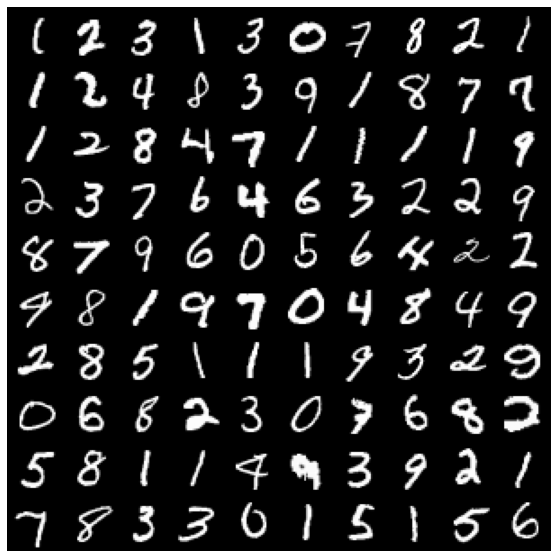

In [ ]:
dataset = MNIST(root='.',
                    download=True,
                    train=True,
                    transform=transforms.ToTensor())

test_dataset = MNIST(root='.',
                    train=False,
                    transform=transforms.ToTensor())
training_batch = DataLoader(dataset, 100, shuffle=True)


def show_sample_image(training_batch):
    for images, labels in training_batch:
        column = 10
        row = math.ceil(len(labels)/10)
        plt.figure(figsize=(row, column))
        plt.axis('off')
        plt.imshow(make_grid(images, nrow=row).permute((1, 2, 0)))
        #plt.show(block=True)
        #print(labels.reshape(10,10))
        break


show_sample_image(training_batch)

**Data**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


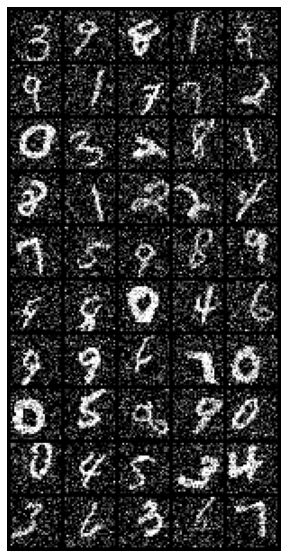

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + t.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
train_tfms = transforms.Compose([transforms.RandomCrop(28, padding=4, padding_mode='constant'), 
                                 transforms.RandomRotation(degrees=(-20,20)),
                                 transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                 transforms.ToTensor(),
                                 AddGaussianNoise(0., 0.3)])

test_tfms = transforms.Compose([transforms.ToTensor()])
new_dataset = MNIST(root='.',
                    download=True,
                    train=True,
                    transform=train_tfms)

new_test_dataset = MNIST(root='.',
                    train=False,
                    transform=test_tfms)
batch_size = 50
training_batch = DataLoader(new_dataset, batch_size, shuffle=True, 
                            num_workers=2, pin_memory=True)
testing_batch = DataLoader(new_test_dataset, 10000, shuffle=False, 
                           num_workers=2, pin_memory=True)
# Let us now check some sample images after using the above data augmentation


def show_sample_image(training_batch):
    for images, labels in training_batch:
        column = 10
        row = math.ceil(len(labels)/10)
        plt.figure(figsize=(row, column))
        plt.axis('off')
        plt.imshow(make_grid(images, nrow=row).permute((1, 2, 0)))
        #plt.show(block=True)
        #print(labels.reshape(10,10))
        break

show_sample_image(training_batch)

**CNN-Resnet Model**

In [ ]:
class ResNet9(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out1 = self.res1(out) + out
        out1 = self.conv3(out1)
        out1 = self.conv4(out1)
        out2 = self.res2(out1) + out1
        out2 = self.classifier(out2)
        return out2
def parameter(model):
    para = 0
    for i in model.parameters():
        para += i.numel()
    return para
model = ResNet9().to(device)
parameter(model)

11589642

**Training**

In [ ]:
def accuracy(outputs, labels):
    with t.no_grad():
        com = F.softmax(outputs, dim=1)
        max_prob, pred_label = t.max(com, dim=1)
        item = pred_label == labels
        return t.sum(item).item() / len(labels)


def loss_batch(model, loss_fn, images, given_labels, opt=None):
    ll = len(images)
    loss = loss_fn(model(images), given_labels)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric = accuracy(model(images), given_labels)
    return loss.item(), ll, metric


def evaluate(model, loss_fn, batch):
    total_loss = 0.
    total_item = 0.
    total_metric = 0.
    with t.no_grad():
        for images, given_labels in batch:
            images = images.to(device)
            given_labels = given_labels.to(device)
            results = loss_batch(model, loss_fn, images, given_labels)
            losses, items, metrics = results
            total_loss += losses * items
            total_item += items
            total_metric += metrics * items
        avg_loss = total_loss / total_item
        avg_metric = total_metric / total_item
    return avg_loss, total_item, avg_metric


def fit(total_epochs, model, loss_fn, opt, train_dl, test_data):
    # training of the model
    t.cuda.empty_cache()
    for epoch in range(total_epochs):
        for image, given_label in train_dl:
            image = image.to(device)
            given_label = given_label.to(device)
            loss_batch(model, loss_fn, image, given_label, opt)
        # checking the model on the test set
        result = evaluate(model, loss_fn, test_data)
        loss,_,metric = result
        print(f"Epoch [{epoch+1}]: test loss = {loss:.4f}, test accuracy = {metric*100:.2f}%")
from timeit import default_timer as timer
start = timer()
loss_fn = F.cross_entropy
print("Training: phase 1")
opt = t.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
fit(2, model, loss_fn, opt, training_batch, testing_batch)
print("Training: phase 2")
opt = t.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
fit(10, model, loss_fn, opt, training_batch, testing_batch)
print("Training: phase 3")
opt = t.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.001)
fit(8, model, loss_fn, opt, training_batch, testing_batch)
end = timer()
print(f"Training time = {end-start} seconds")

In [ ]:
t.save(model.state_dict(), 'MNIST_ResNet.pth')

In [ ]:
with t.no_grad():
    for images, given_labels in testing_batch:
            images = images.to(device)
            given_labels = given_labels.to(device)
            outputs = model(images)
            com = F.softmax(outputs, dim=1)
            max_prob, pred_label = t.max(com, dim=1)
            item = pred_label == given_labels
            print(item)

tensor([True, True, True,  ..., True, True, True])


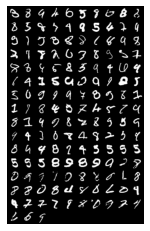

In [ ]:
with t.no_grad():
    missed_images = []
    predicted_labels = []
    correct_labels = []
    for images, given_labels in testing_batch:
      for i in range(10000):
        if item[i] == False:
          missed_images.append(images[i])
          predicted_labels.append(pred_label[i].item())
          correct_labels.append(given_labels[i].item())
# Let's now see all the missed images from the test set
column = 4
row = 10
plt.figure(figsize=(row, column))
plt.axis('off')
plt.imshow(make_grid(missed_images, nrow=row).permute((1, 2, 0)))

In [ ]:
print("Predicted Labels:")
print(predicted_labels[:10])
print(predicted_labels[10:20])
print(predicted_labels[20:30])
print(predicted_labels[30:40])

Predicted Labels:
[8, 2, 4, 2, 0, 3, 9, 0, 0, 2]
[2, 3, 9, 4, 9, 9, 3, 6, 2, 4]
[2, 1, 2, 0, 2, 2, 6, 6, 4, 9]
[7, 9, 7, 7, 6, 7, 6, 8, 2, 2]


In [ ]:
print("Correct Labels:")
print(correct_labels[:10])
print(correct_labels[10:20])
print(correct_labels[20:30])
print(correct_labels[30:40])

Correct Labels:
[3, 8, 9, 4, 6, 5, 8, 6, 8, 8]
[8, 5, 8, 7, 4, 8, 5, 4, 7, 9]
[9, 7, 5, 8, 8, 8, 1, 8, 9, 8]
[2, 7, 8, 2, 0, 3, 8, 9, 5, 7]
